# Read model during iteration

In [7]:
from pytomoatt.data import ATTData
import numpy as np

In [8]:
# file to be read
input_file = 'OUTPUT_FILES/OUTPUT_FILES_fields/out_data_sim_group_0.h5'
# input parameters file
par_file = '3_input_params/input_params_inv.yaml'
# grid file
grid_file = 'OUTPUT_FILES/OUTPUT_FILES_fields/out_data_grid.h5'

# read velocity at 2nd iteration
group   = "model"           
dataset = "vel_inv_0002"    
data = ATTData.read(input_file, par_file, grid_file, group, dataset)
data_field = data.to_xarray()

# we can interp it to a 2D slice at depth
depth = 0.0
tmp = data_field.interp_dep(depth, field=dataset)
longitude   = tmp[:,0]
latitude    = tmp[:,1]
vel         = tmp[:,2]

# we read initial velocity model
dataset = "vel_inv_0000"    
data = ATTData.read(input_file, par_file, grid_file, group, dataset)
data_field = data.to_xarray()
vel_init = data_field.interp_dep(depth, field=dataset)[:,2]

# calculate velocity perturbation
vel_pert = (vel - vel_init)/vel_init * 100.0

# Similarly, we do the same process for xi and eta
dataset = "xi_inv_0002"
data = ATTData.read(input_file, par_file, grid_file, group, dataset)
data_field = data.to_xarray()
xi = data_field.interp_dep(depth, field=dataset)[:,2]

dataset = "eta_inv_0002"
data = ATTData.read(input_file, par_file, grid_file, group, dataset)
data_field = data.to_xarray()
eta = data_field.interp_dep(depth, field=dataset)[:,2]

# calculate epsilon (magnitude of anisotropy)
epsilon = np.sqrt(xi**2 + eta**2)


# prepare for plotting fast velocity directions
# magnitude and direction of anisotropy
dataset = "xi_inv_0002"
data = ATTData.read(input_file, par_file, grid_file, group, dataset)
data_field = data.to_xarray()
tmp     = data_field.interp_dep(depth, field=dataset, samp_interval=20) # fast velocity direction, samp_interval is the sampling one point every 20 points in each axis
ani_lon = tmp[:,0]
ani_lat = tmp[:,1]
ani_xi  = tmp[:,2]

dataset = "eta_inv_0002"
data = ATTData.read(input_file, par_file, grid_file, group, dataset)
data_field = data.to_xarray()
ani_eta    = data_field.interp_dep(depth, field=dataset, samp_interval=20)[:,2] # fast velocity direction, samp_interval is the sampling one point every 20 points in each axis

ani_epsilon = np.sqrt(ani_xi**2 + ani_eta**2)
ani_phi     = np.rad2deg(0.5*np.arctan2(ani_eta, ani_xi))

# Pygmt kernel density

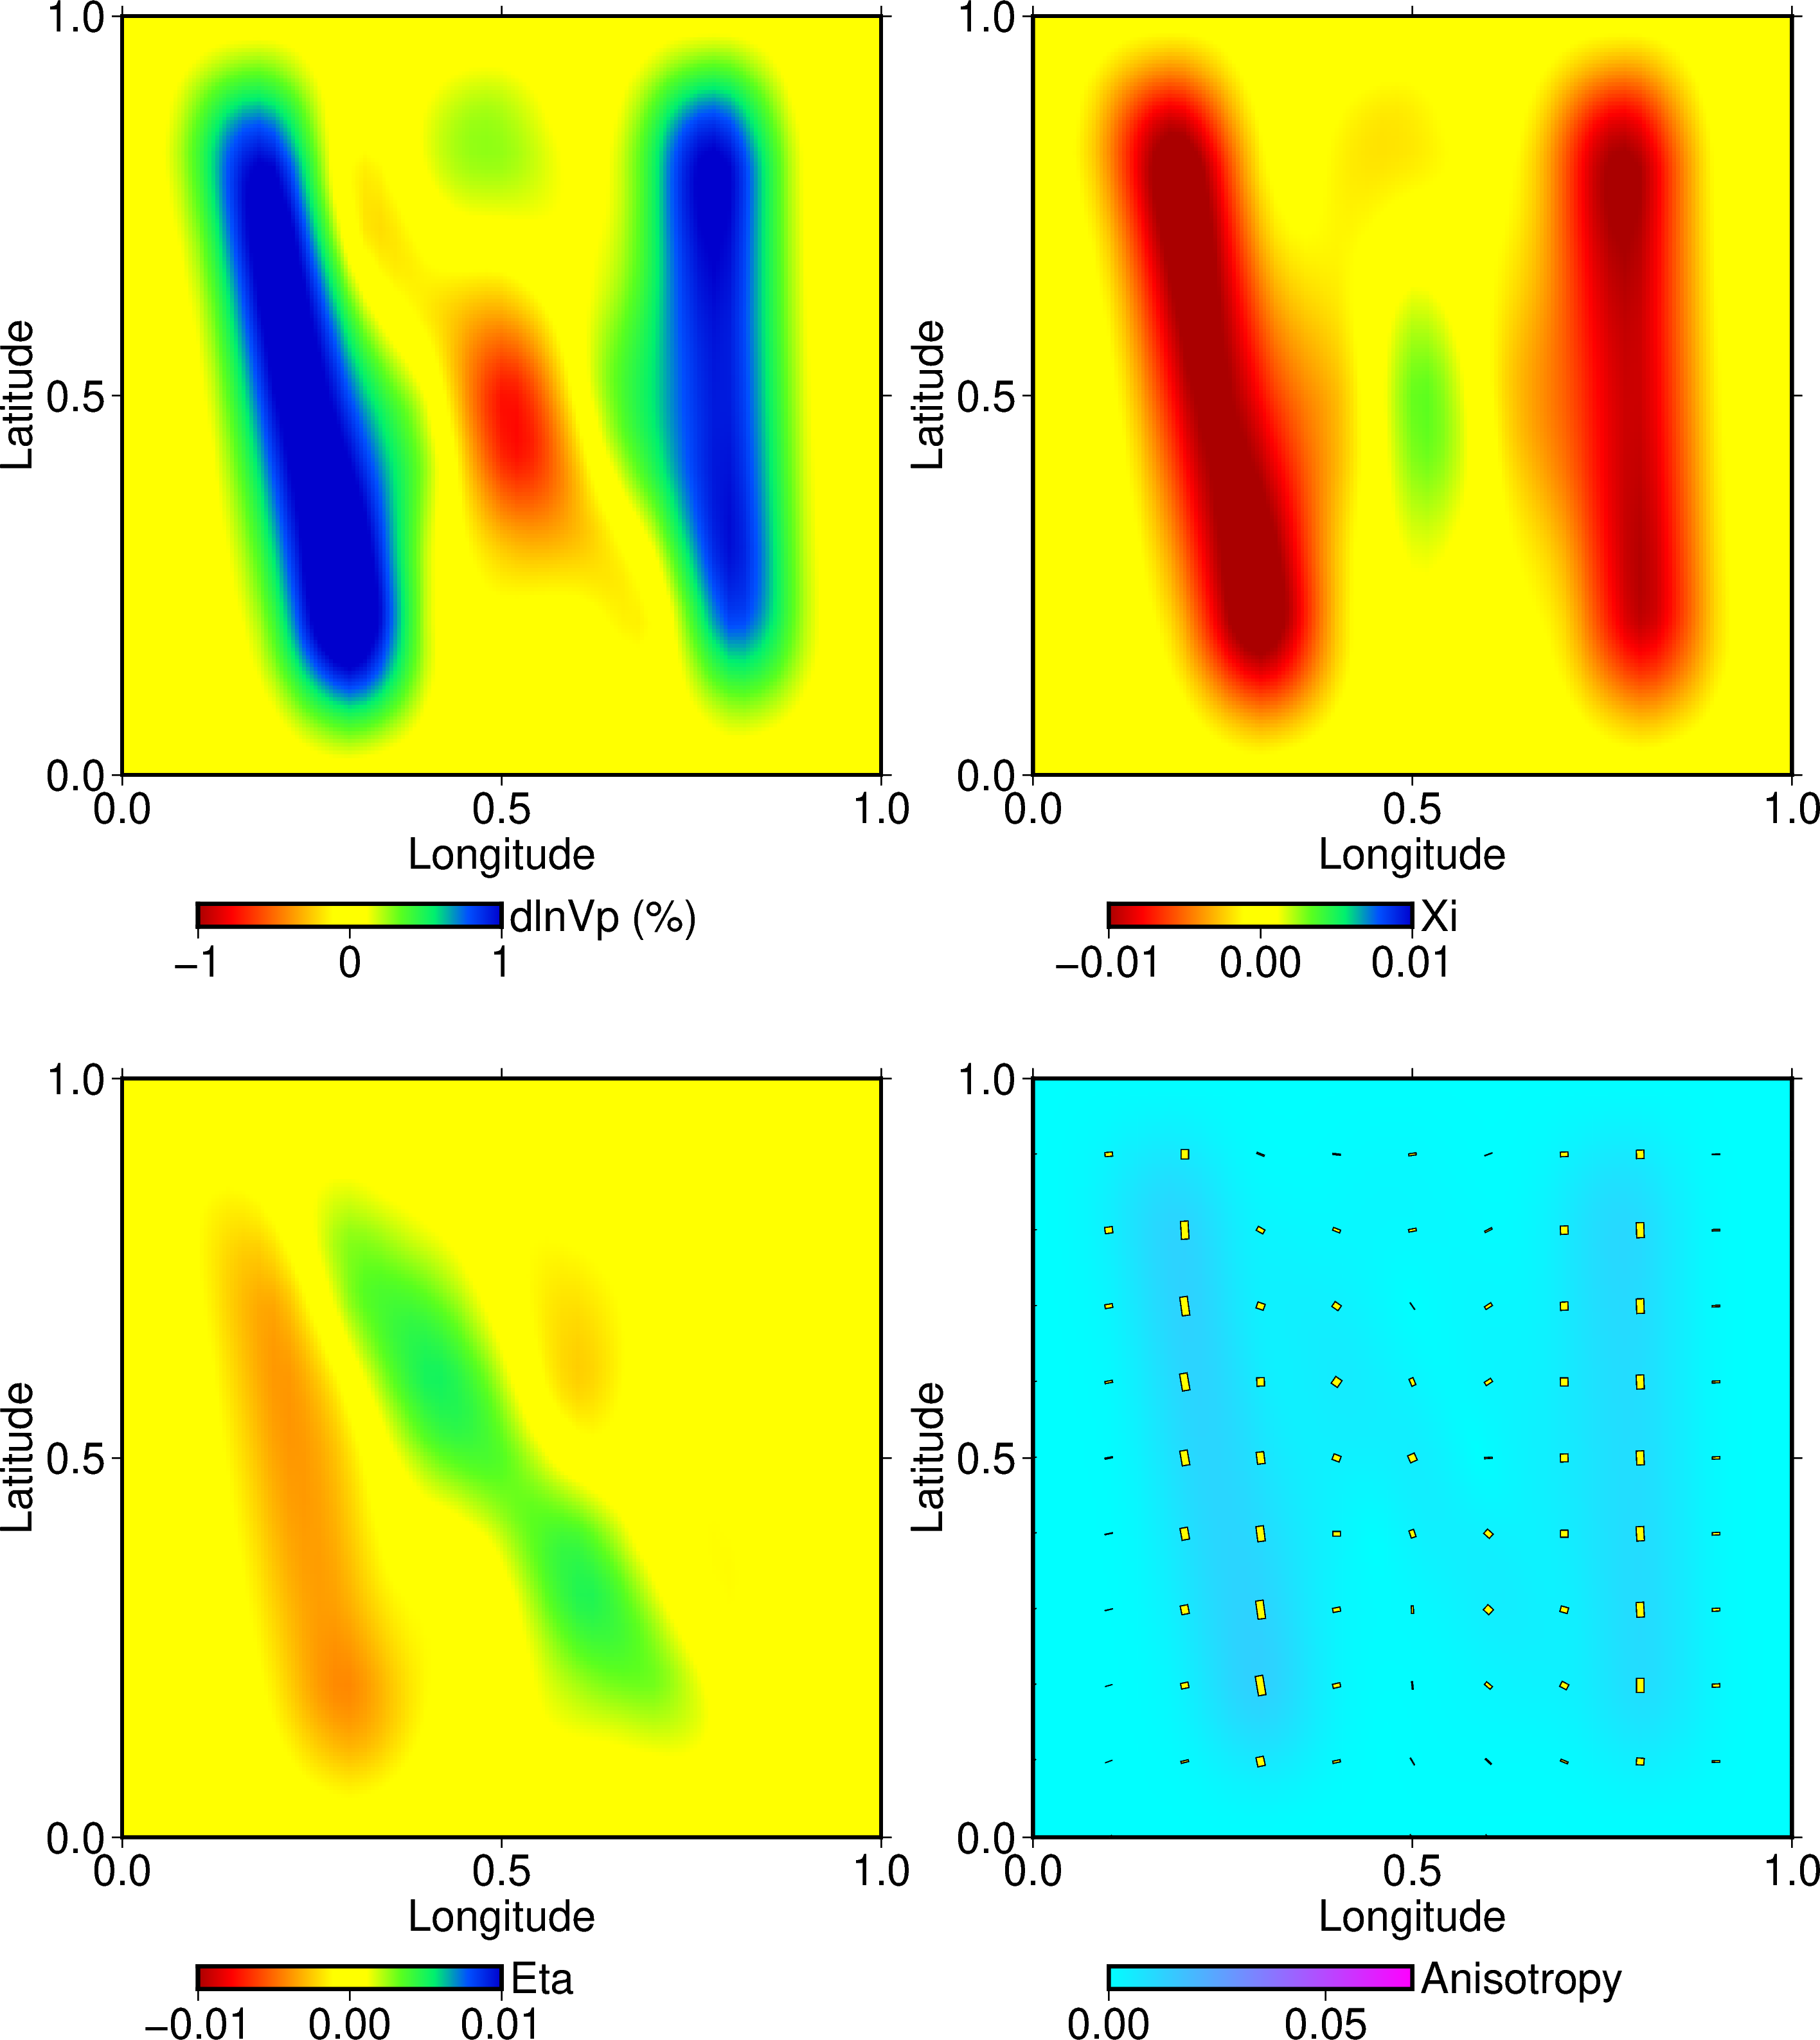

In [9]:
# pygmt plot
import pygmt
pygmt.config(FONT="16p", IO_SEGMENT_MARKER="<<<")

region = [0,1,0,1]
projection = "X10c/10c"
frame = ["xa0.5+lLongitude", "ya0.5+lLatitude", "nSWe"]

fig = pygmt.Figure()

# ----------- plot velocity model ------------
pygmt.makecpt(cmap="seis", series=[-1, 1], background=True, reverse=False)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=vel_pert, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(1),"y+ldlnVp (%)"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

# ----------- plot xi model ------------
fig.shift_origin(xshift= 12)
pygmt.makecpt(cmap="seis", series=[-0.01, 0.01], background=True, reverse=False)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=xi, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(0.01),"y+lXi"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

# ----------- plot eta model ------------
fig.shift_origin(xshift= -12, yshift=-14)
pygmt.makecpt(cmap="seis", series=[-0.01, 0.01], background=True, reverse=False)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=eta, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(0.01),"y+lEta"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

# ----------- plot fast velocity direction ------------
fig.shift_origin(xshift= 12)
pygmt.makecpt(cmap="cool", series=[0, 0.07], background=True)
grid = pygmt.xyz2grd(x=longitude, y=latitude, z=epsilon, spacing=0.005,region=region,)
fig.grdimage(frame=frame,grid = grid,projection=projection, region=region) # nan_transparent may work

ani = np.hstack([ani_lon[:,None], ani_lat[:,None], ani_phi[:,None], ani_epsilon[:,None]*20, np.ones((ani_phi.shape[0],1))*0.1])
fig.plot(ani, style='j', fill='yellow1', pen='0.3p,black')

fig.shift_origin(xshift= 1, yshift=-2)
fig.colorbar(frame = ["a%f"%(0.05),"y+lAnisotropy"], position="+w4c/0.3c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平
fig.shift_origin(xshift=-1, yshift=+2)

fig.show()
fig.savefig('img/6a_intermediate_model.png')